# Préparation des fichiers

Les fichiers *fastq.gz* obtenus ont été concaténés en un fichier grâce à la commande bash *cat*.

In [ ]:
cat *.fastq.gz > PXX_CXX_BarcodeXX_all.fastq.gz
#Les 'XX' correspondent ici aux numéros des passages, échantillons et barcodes

<br>

# Pipeline *snakemake*

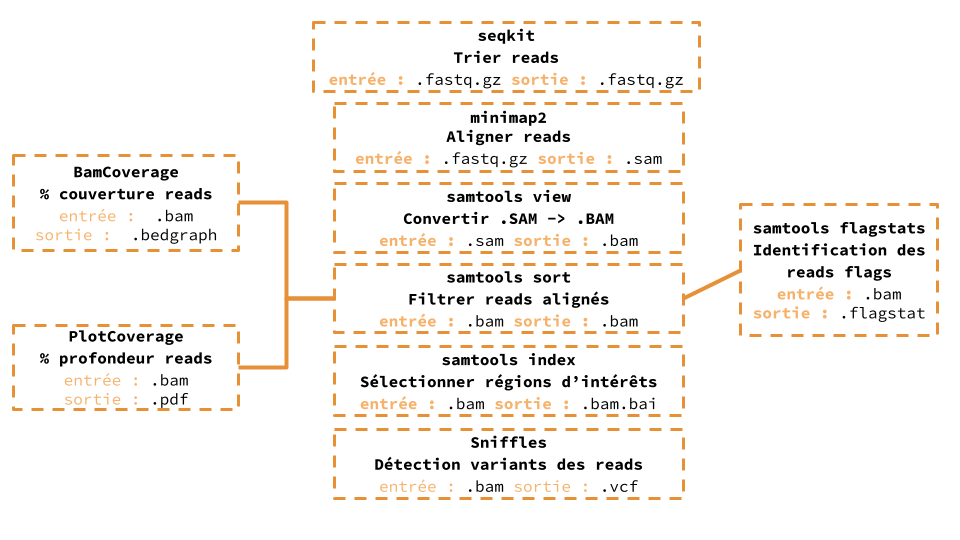

**Schéma récapitulatif du fonctionnement de la pipeline \[Noëlie Palermo, M1 Bioinformatique\]**

<br>

Le dossier contenant la pipeline a été téléchargé depuis *github*.

In [ ]:
git clone https://github.com/asfistonlavie/BILL.git
#Ligne de commande permet de télécharger le dossier depuis le dépôt github

Le dossier téléchargé contient deux fichiers de configuration *yaml*, un fichier *snakemake* et un fichier *sh*.

Le dossier contient également un programme supplémentaire, *extract_sv.py*, non nécessaire au fonctionnement de la pipeline.

<br>

## Fichiers de configuration

### Fichier *config.yaml*

Le premier fichier de configuration, *config.yaml*, contient les chemins permettant d'accéder aux différents dossiers nécessaires au fonctionnement de la pipeline. Il contient également des informations telles que le nom de la référence, la taille minimale des reads à sélectionner, ainsi que la taille du génome complet.

In [1]:
raw_dir: "Analyse/"
ref_dir: "../Ref/"
res_dir: "Analyse/"
log_dir: "LOGS/Ref/"
ben_dir: "BENCHMARKS/Ref/"
#Définition des variables contenant les chemins menant aux dossiers

ref_file: "reference_KHVJ_TUMST1.fa"
trim: 1000
genome_size: 295052

### Fichier *cluster_config.yaml*

Le deuxième fichier de configuration, *cluster_config.yaml*, contient la puissance de calcul (*CPU*) et la mémoire à accès aléatoire (*RAM*) allouées à la pipeline.

On retrouve une règle par défault s'appliquant à toute la pipeline, ainsi que des règles spécifiques aux outils de la pipeline.

In [ ]:
__default__:
    job-name: "{rule}"
    queue: "fast"
    nodes: "--nodes=1"
    cpus: "--cpus-per-task=1"
    mem: "--mem=1G"
    log: "--output=LOGS/P1/{rule}.log"

seqkit_trim:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=2"
    mem: "--mem=8G"
    log: "--output=LOGS/P1/SEQKIT/{rule}.log"

minimap2:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=4"
    mem: "--mem=8G"
    log: "--output=LOGS/P1/MINIMAP2/{rule}.log"

samtools_view:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=2"
    mem: "--mem=8G"
    log: "--output=LOGS/P1/SAMTOOLS/{rule}.log"

samtools_sort:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=2"
    mem: "--mem=8G"
    log: "--output=LOGS/P1/SAMTOOLS/{rule}.log"

samtools_flagstat:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=2"
    mem: "--mem=8G"
    log: "--output=LOGS/P1/SAMTOOLS/{rule}.log"

samtools_index:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=2"
    mem: "--mem=8G"
    log: "--output=LOGS/P1/SAMTOOLS/{rule}.log"

bam_coverage:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=4"
    mem: "--mem=8G"
    log: "--output=LOGS/P1/DEEPTOOLS/{rule}.log"

plot_coverage:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=8"
    mem: "--mem=64G"
    log: "--output=LOGS/P1/DEEPTOOLS/{rule}.log"

sniffles:
    job-name: "{rule}:{wildcards.sample}"
    cpus: "--cpus-per-task=4"
    mem: "--mem=16G"
    log: "--output=LOGS/P1/SNIFFLES/{rule}.log"

<br>

## Fichier *snakefile*

Le fichier *snakefile* (équivalent d'un *makefile*) permet d'établir des règles nécessaires à l'utilisation des outils et l'automatisation de la pipeline.

In [ ]:
configfile: "SCRIPTS/config.yaml"
#Indication du chemin du fichier de configuration

RAW_DIR = config["raw_dir"]
REF_DIR = config["ref_dir"]
RES_DIR = config["res_dir"]
LOG_DIR = config["log_dir"]
BEN_DIR = config["ben_dir"]
#Définition des variables contenant les chemins menant aux dossiers (à partir du fichier de configuration)

trim = str(config["trim"])
genomeSize = str(config["genome_size"])
#Initialisation de la taille minimale de reads sélectionnés, la taille du génome, etc. (à partir du fichier de configuration)
filesP15 = ["P15.1_RB01", "P15.2_RB02", "P15.3_RB03", "P15.4_RB01", "P15.5_RB02", "P15.6_RB04", "P15.7_RB03", "P15.8_RB05", "P15.9_RB04", "P15.10_RB05"]
filesP30 = ["P30.1_RB06", "P30.2_RB07", "P30.3_RB08", "P30.4_RB06", "P30.5_RB07", "P30.6_RB08", "P30.6_RB09", "P30.7_RB10", "P30.8_RB10", "P30.9_RB11", "P30.10_RB12"]

Une règle commune à l'ensemble de la pipeline est définie en premier.

In [ ]:
rule all:
	input:
		expand(RES_DIR + "P15/{sample}/{sample}.trimed" + trim + ".mapped.sorted.vcf", sample=filesP15),
		expand(RES_DIR + "P30/{sample}/{sample}.trimed" + trim + ".mapped.sorted.vcf", sample=filesP30),
	benchmark:
		BEN_DIR + "all.txt"

<br>

On retrouve ensuite neuf règles spécifiques aux outils de la pipeline, une par outil.

Le premier outil est l’outil *seqkit seq*.

In [ ]:
rule seqkit_trim:
	input:
		raw=RAW_DIR + "{P}/{sample}.fastq.gz"
	output:
		trimed=protected(RAW_DIR + "{P}/{sample}.trimed" + trim + ".fastq.gz")
	log:
		out=LOG_DIR + "SEQKIT/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "SEQKIT/{P}/{sample}.txt"
	threads: 2
	shell:
		"""
		seqkit seq -m {trim} {input.raw} -o {output.trimed} 2> {log.out}
		"""

Cet outil prend en entrée un fichier *fastq*, contenant les reads. Le but de cet outil est de retirer les reads dont la longueur est inférieure à 1000 paire de bases. Le fichier de sortie est encore un fichier *fastq*, où l’on retrouve les reads trimmés.

<br>

Le second outil est l’outil *minimap2*.

In [ ]:
rule minimap2:
	input:
		read=rules.seqkit_trim.output,
		ref=REF_DIR + config["ref_file"]
	output:
		sam=temp(RES_DIR + "{P}/{sample}/{sample}.trimed" + trim + ".sam")
	log:
		out=LOG_DIR + "MINIMAP2/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "MINIMAP2/{P}/{sample}.txt"
	threads: 4
	shell:
		"""
		minimap2 --MD -ax map-ont -t {threads} {input.ref} {input.read} -o {output.sam} 2> {log.out}
		"""

Cet outil prend en entrée le fichier *fastq* obtenu précédemment, contenant les reads trimmés, et un fichier *fasta* contenant la séquence de référence. Le but de cet outil est d’aligner ces reads à la séquence. Le fichier de sortie est donc un fichier *sam* où l’on trouve les reads alignés.

<br>

Le troisième outil est l’outil *samtools view*.

In [ ]:
rule samtools_view:
	input:
		sam=rules.minimap2.output
	output:
		mapped=temp(RES_DIR + "{P}/{sample}/{sample}.trimed" + trim + ".mapped.bam")
	log:
		out=LOG_DIR + "SAMTOOLS/VIEW/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "SAMTOOLS/VIEW/{P}/{sample}.txt"
	threads: 2
	shell:
		"""
		samtools view -uhbS -@ {threads} -F 4 {input.sam} -o {output.mapped} 2> {log.out}
		"""

Cet outil prend en entrée le fichier *sam* obtenu précédemment, contenant les reads alignés. Le but de cet outil est de retirer les reads ne s’alignant pas à la référence, puis d’inscrire les reads restants en format binaire. Le fichier de sortie est donc un fichier *bam*, qui est un fichier *sam* binarisé.

<br>

Le quatrième outil est l’outil *samtools flagstat*.

In [ ]:
rule samtools_flagstat:
	input:
		sorted=rules.minimap2.output
	output:
		stats=protected(RES_DIR + "{P}/{sample}/{sample}.trimed" + trim + ".flagstat")
	log:
		out=LOG_DIR + "SAMTOOLS/FLAGSTAT/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "SAMTOOLS/FLAGSTAT/{P}/{sample}.txt"
	threads: 2
	shell:
		"""
		samtools flagstat -@ {threads} {input.sorted} > {output.stats} 2> {log.out}
		"""

Cet outil prend en entrée le fichier *bam* obtenu grâce à *samtools view*. Le but de cet outil est de produire des statistiques à partir des valeurs de *flags* des reads. Le fichier de sortie est un fichier *flagstat* contenant ces statistiques. Ce fichier est l’un des fichiers renvoyés en fin de pipeline.

<br>

Le cinquième outil est l’outil *samtools sort*.

In [ ]:
rule samtools_sort:
	input:
		mapped=rules.samtools_view.output
	output:
		sorted=protected(RES_DIR + "{P}/{sample}/{sample}.trimed" + trim + ".mapped.sorted.bam")
	log:
		out=LOG_DIR + "SAMTOOLS/SORT/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "SAMTOOLS/SORT/{P}/{sample}.txt"
	threads: 2
	shell:
		"""
		samtools sort -l 0 -@ {threads} {input.mapped} -o {output.sorted} 2> {log.out}
		"""

Cet outil prend en entrée le fichier *bam* obtenu grâce à *samtools view*. Le but de cet outil est d’ordonner les reads alignés selon leurs coordonnées (c’est-à-dire leur position sur la séquence de référence). Le fichier de sortie est un fichier *bam* contenant les reads ordonnés.

<br>

Le sixième outil est l’outil *plotCoverage*.

In [ ]:
rule plot_coverage:
	input:
		sorted=rules.samtools_sort.output
	output:
		pdf=protected(RES_DIR + "{P}/{sample}/{sample}.trimed" + trim + ".mapped.sorted.pdf")
	log:
		out=LOG_DIR + "DEEPTOOLS/PLOT/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "DEEPTOOLS/PLOT/{P}/{sample}.txt"
	threads: 8
	shell:
		"""
		plotCoverage -p {threads} -b {input.sorted} --smartLabels --plotFileFormat pdf -o {output.pdf} 2> {log.out}
		"""

Cet outil prend en entrée le fichier *bam* obtenu à la sortie de *samtools sort*. Le but de cet outil est de produire des graphiques permettant de visualiser la profondeur des reads. Le fichier de sortie est un fichier *pdf* contenant les graphiques obtenus. 

<br>

Le septième outil est l’outil *bamCoverage*.

In [ ]:
rule bam_coverage:
	input:
		sorted=rules.samtools_sort.output
	output:
		bedgraph=protected(RES_DIR + "{P}/{sample}/{sample}.trimed" + trim + ".mapped.sorted.bedgraph")
	log:
		out=LOG_DIR + "DEEPTOOLS/COVERAGE/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "DEEPTOOLS/COVERAGE/{P}/{sample}.txt"
	threads: 4
	shell:
		"""
		bamCoverage -p {threads} -b {input.sorted} -of "bedgraph" --effectiveGenomeSize {genomeSize} --normalizeUsing RPGC -o {output.bedgraph} 2> {log.out}
		"""

Cet outil prend en entrée le fichier *bam* obtenu à la sortie de *samtools sort*. Le but de cet outil est de produire une visualisation de la couverture des reads. Le fichier de sortie est un fichier *bedgraph*, que l’on peut ouvrir dans le logiciel *IGV* afin de visualiser la couverture le long de la référence. 

<br>

Le huitième outil est l’outil *samtools index*.

In [ ]:
rule samtools_index:
	input:
		sorted=rules.samtools_sort.output
	output:
		index=protected(RES_DIR + "{P}/{sample}/{sample}.trimed" + trim + ".mapped.sorted.bam.bai")
	log:
		out=LOG_DIR + "SAMTOOLS/INDEX/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "SAMTOOLS/INDEX/{P}/{sample}.txt"
	threads: 2
	shell:
		"""
		samtools index -@ {threads} {input.sorted} 2> {log.out}
		"""

Cet outil prend en entrée le fichier *bam* obtenu à la sortie de *samtools sort*. Le but de cet outil est de créer un index des reads selon les régions d’intérêts. Le fichier de sortie est un fichier *bam.bai* contenant cet index.

<br>

Le neuvième outil est l’outil *sniffles*.

In [ ]:
rule sniffles:
	input:
		sorted=rules.samtools_sort.output,
		bai=rules.samtools_index.output
	output:
		vcf=protected(RES_DIR + "{P}/{sample}/{sample}.trimed" + trim + ".mapped.sorted.vcf")
	log:
		out=LOG_DIR + "SNIFFLES/{P}/{sample}.log"
	benchmark:
		BEN_DIR + "SNIFFLES/{P}/{sample}.txt"
	threads: 4
	shell:
		"""
		sniffles -t {threads} -i {input.sorted} --minsvlen 30 --minsupport 10 -v {output.vcf} 2> {log.out}
		"""

Cet outil prend en entrée le fichier *bam* obtenu à la sortie de *samtools sort*, ainsi que le fichier *bam.bai* obtenu avec *samtools index*. Le but de cet outil est d’identifier les variants structurels d’une longueur d’au moins 30 nucléotides. Le fichier de sortie est un fichier *vcf* contenant les variants structurels détectés.

<br>

## Fichier *shell*

Les différents outils de la pipeline sont chargés grâce à un fichier *sh*.

In [ ]:
path="/shared/projects/recombinationlandscape/ARNAUD_STAGE/bill"

module load snakemake/6.14.0 #module snakemake pour la gestion de la pipeline
module load minimap2/2.17 #module minimap2
module load seqkit/2.1.0 #module seqkit pour l'utilisation de la fonction seq
module load samtools/1.9 #module samtools pour l'utilisation des fonctions view, flagstat, sort et index
module load sniffles/1.0.11 #module sniffles
module load python/3.7 #module python pour exécuter les scripts python
module load deeptools/3.5.0 #module deeptools pour l'utilisation de plotCoverage et bamCoverage

snakemake -s SCRIPTS/Snakefile --cores 1 --keep-going --cluster-config SCRIPTS/cluster_config.yaml --cluster "sbatch -J {cluster.job-name} -A recombinationlandscape -p {cluster.queue} {cluster.nodes} {cluster.cpus} {cluster.log} {cluster.mem}" --jobs 5

La dernière ligne de code permet de lancer le script de la pipeline.

L'option *--cores 1* spécifie le nombre de cœurs utilisés pour l'exécution de la pipeline.
<br>
L'option *--keep-going* permet à snakemake de continuer l'exécution des jobs même si certains échouent.
<br>
L'option *--cluster-config SCRIPTS/cluster_config.yaml* permet de spécifier le fichier de configuration pour la gestion de clusters.
<br>
Les options *--cluster "sbatch -J {cluster.job-name} -A recombinationlandscape -p {cluster.queue} {cluster.nodes} {cluster.cpus} {cluster.log} {cluster.mem}"* spécifient les paramètres du cluster utilisé pour l'exécution des jobs.
<br>
L'option *--jobs 5* spécifie le nombre maximal de jobs à exécuter simultanément.

<br>

## Programme *extract_sv.py*

Ce programme permet d'extraire les variants structurels à partir du fichier *vcf* produit par la pipeline. Le fichier produit est un fichier *csv* contenant les variants, leur nature (insertions ou délétions) ainsi que leur position sur le génome.

In [ ]:
#Import des modules python nécessaires
import sys
import os
import csv
import re

#Définition d'une fonction permettant d'ajouter les variants à une liste
def parse_vcf(variants, reader, sample):
	for line in reader:
		if line[0].startswith('#') is False:
			variants.append(read_line_vcf(line, sample))
	
	return variants

#Définition d'une fonction permettant de lire les lignes d'un fichier vcf
def read_line_vcf(line, sample):
	variant = []

	variant.append(sample)
	variant.append(int(line[1]))
	variant.append(re.search('[A-Z]{3}', re.search('=[A-Z]{3}', re.search('SVTYPE=[A-Z]{3}', line[7]).group(0)).group(0)).group(0))
	variant.append(re.search('[0-9]+', re.search('SVLEN=-?[0-9]+', line[7]).group(0)).group(0))
	if variant[2] == "DEL":
		variant.append(line[3])
	elif variant[2] == "INS":
		variant.append(line[4])
	
	return variant

#Fonction principale du programme
def main():
	extension = sys.argv[1]
	variants = []

	for root, directories, files in os.walk(sys.argv[2]):
		for fi in files:
			if fi.endswith(extension):
				# extract sample name in file name
				sample = str(fi.split('.')[0] + '.' + fi.split('.')[1])

				# open vcf file in csv reader
				vcfFile = open(os.path.join(root, fi))
				vcfReader = csv.reader(vcfFile, delimiter='\t')

				# extract SV from vcf file
				variants = parse_vcf(variants, vcfReader, sample)

				vcfFile.close()
	
	variants = sorted(variants, key=lambda x: (x[1], x[0]))
	insertions = [variant for variant in variants if variant[2] == "INS"]
	deletions = [variant for variant in variants if variant[2] == "DEL"]

        print("")

	print("insertions")
	for v in insertions:
		print(v[0], v[1], v[2], v[3], v[4], sep="\t", end="\n")
	print("deletion")
	for v in deletions:
		print(v[0], v[1], v[2], v[3], v[4], sep="\t", end="\n")
        

#Lancement du programme et gestion des mauvais usages de celui-ci
if __name__ == "__main__":
	if len(sys.argv) != 3:
		print("Usage: extract_sv.py <extension> <res_directory>")
		exit()
	main()

<br>

# Génération de séquences consensus grâce à *Geneious*

Les séquences consensus ont d'abord été générées avec l'outil *medaka*, sous conseil d'Arnaud Soulier. Cependant, cet outil complète les zones à la couverture trop faible avec la séquence de référence, ce qui biaise notre génome et donc notre arbre de distance génétique.

In [ ]:
medaka consensus ../../Resultats/bam/P10.C6_RB03.trimed1000.mapped.sorted.bam Scaffold_P10_C6.hdf

La fonction medaka consensus prend un fichier *sam* ou *bam* en entrée et renvoie un fichier *hdf* contenant un scaffold obtenu en utilisant une méthode de machine learning.

In [ ]:
medaka stitch Scaffold_P10_C6.hdf ../Analyse/reference_KHVJ_TUMST1.fa P10_C6_stitch.fasta

La fonction medaka stitch prend un fichier *hdf* en entrée (premier argument) et renvoie un fichier *fasta* (trosième argument). Cette commande a pour but de remplir les trous du génome consensus avec la référence donnée en deuxième argument.

<br>

L'outil finalement choisi est le logiciel *Geneious*, sous conseil d'Emmanuel Douzery. Cet outil permet de générer une séquence consensus en remplaçant les zones à la couverture trop faible par des "N", des "?", des gaps ou bien la référence.

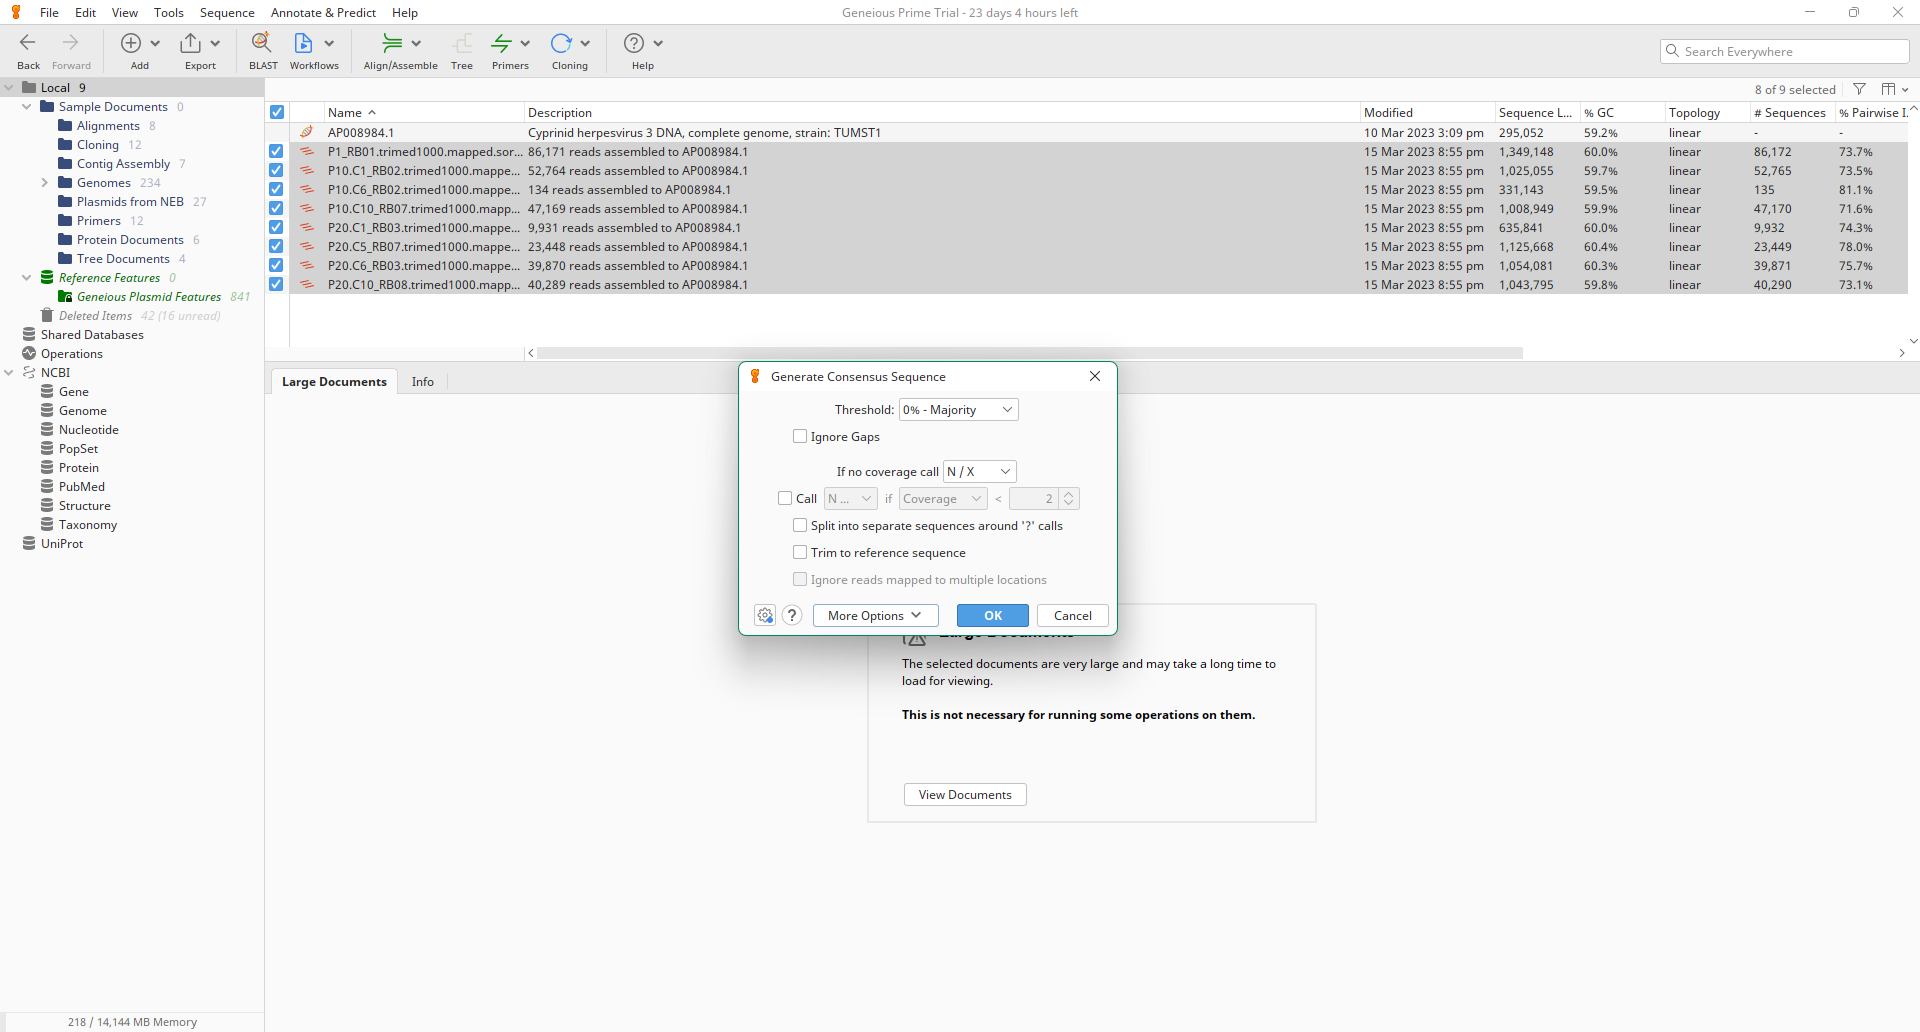

<br>

# Outil d'alignement *mafft*

Plusieurs outils d'alignement (outil intégré dans *Geneious*, méthode *muscle* et *Clustal Omega* depuis *Geneious* et *seaview*) ont été testés en vain, dû à la taille significative des génomes à aligner (300 kbp).

Le seul outil ayant fonctionné ait l'outil *mafft*, lançable depuis le terminal grâce à une commande *bash*.

In [ ]:
mafft inputFile.fasta > outputFile.fasta

L'outil prend en entrée un fichier *fasta* contenant les séquences à aligner, et renvoie un alignement des séquences qu'il inscrit dans un nouveau fichier *fasta*.

<br>

# Génération d'arbres phylogénétiques grâce à *seaview*

L'outil utilisé pour générer les arbres est l'outil *seaview*. La méthode choisie fut la méthode de distance *BioNJ*, en utilisant la distance *HKY*.

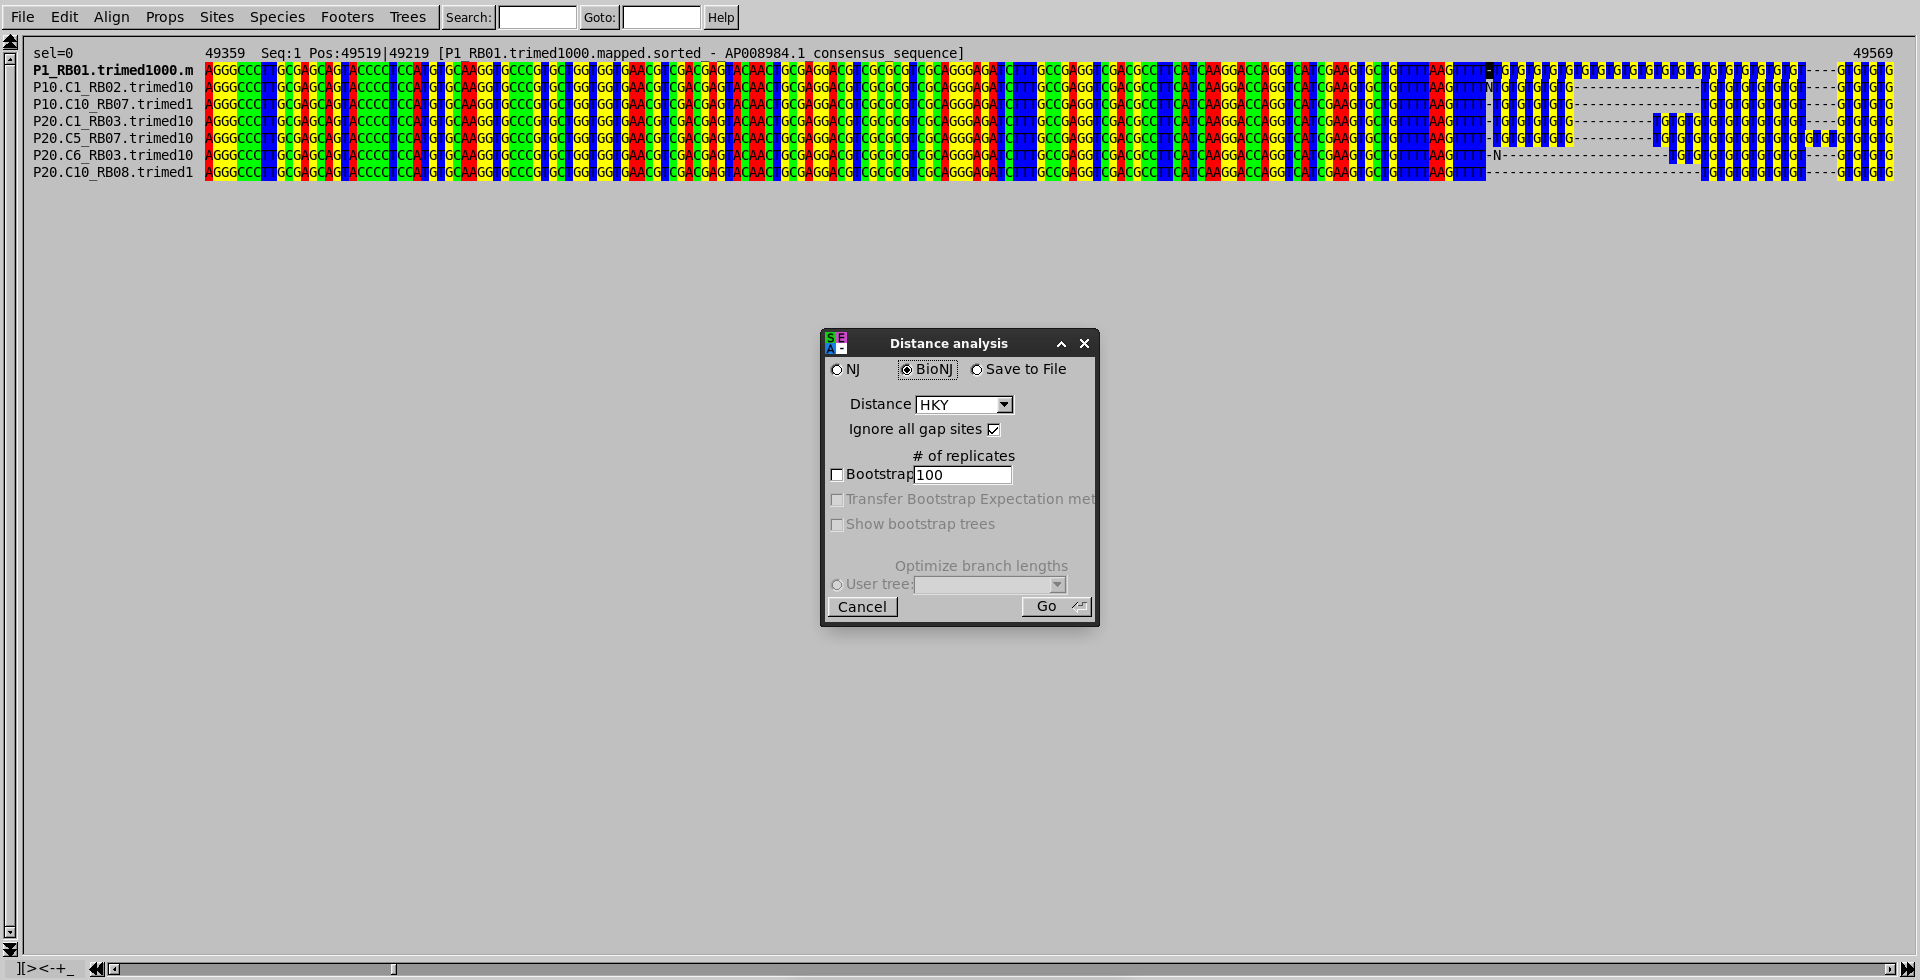